In [76]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [77]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [78]:
# SQL query
# After an initial run, I saw sales numbers up to 30B.  This seemed very
# high to me. After further investigation, I found that multiple stores
# share the same size.  This means we're aggregating weekly sales across
# multiple stores when the store sizes match. The only way I found to 
# address this was to take the average sales between all stores that had
# the same size.  For stores with no store size duplicates, the weekly
# sales and average weekly sales will be identical.
# sql = """
# SELECT 
#   wsd.store_size,
#   COUNT(wft.store_id) AS store_count,
#   SUM(wft.store_weekly_sales) AS weekly_sales,
#   SUM(wft.store_weekly_sales) / COUNT(wft.store_id) AS avg_sales_per_store
# FROM 
#   walmart_fact_table wft
# JOIN
#   walmart_store_dim wsd
# ON
#   wft.store_id = wsd.store_id
# GROUP BY 1
# ORDER BY 1
# """

# In an attempt to match the area chart included in the project documentation,
# the SQL below was used.
sql_sales_by_store_type = """
SELECT 
    wsd.store_type,
    SUM(wft.store_weekly_sales) AS total_sales
FROM 
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN
    WALMART_DB.SILVER.walmart_store_dim wsd
ON
    wft.store_id = wsd.store_id
WHERE 
    wsd.store_size IS NOT NULL
GROUP BY 1
"""

# The following SQL is for the grouped horizontal bar chart.

sql_sales_by_store_type_and_store_id = """
SELECT
    wft.store_id,
    wsd.store_type,
    SUM(wft.store_weekly_sales) AS total_sales
FROM
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN
    WALMART_DB.SILVER.walmart_store_dim wsd
ON
    wft.store_id = wsd.store_id
GROUP BY
    1,2
ORDER BY
    2,3 DESC
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql_sales_by_store_type)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)

# Convert the store size to a string 
# plotly create a more managable range for the y-axis
# df['store_size'] = df['store_size'].astype(str)


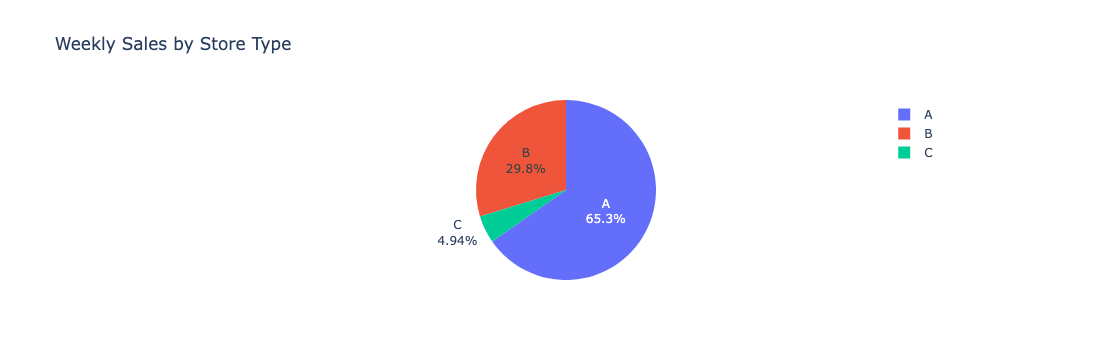

In [79]:
# THIS PIE CHART IS FOR WEEKLY SALES BY STORE TYPE
# Plot using Plotly

# # Create some hover text
# df['hover_text'] = (
#     'Store Type: ' + df['store_type'] +
#     '<br>Month: ' + df['month_name'] +
#     '<br>Sales: $' + df['weekly_sales'].round(2).map('{:,.2f}'.format)
# )

fig = px.pie(
    df,
    names='store_type',
    values='total_sales',
    title='Weekly Sales by Store Type'
    # hole=0.4  # optional - makes it a donut chart
)

fig.update_traces(textinfo="label+percent", hovertemplate="%{label}: $%{value:,.2f}")



fig.show()

In [9]:
print(f"${1234567.8912:,.2f}")

$1,234,567.89


In [26]:
s = ['A', 'B', 'C']
print (s[::-1])

['C', 'B', 'A']


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_67776/597954381.py:5: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



['C' 'B' 'A']


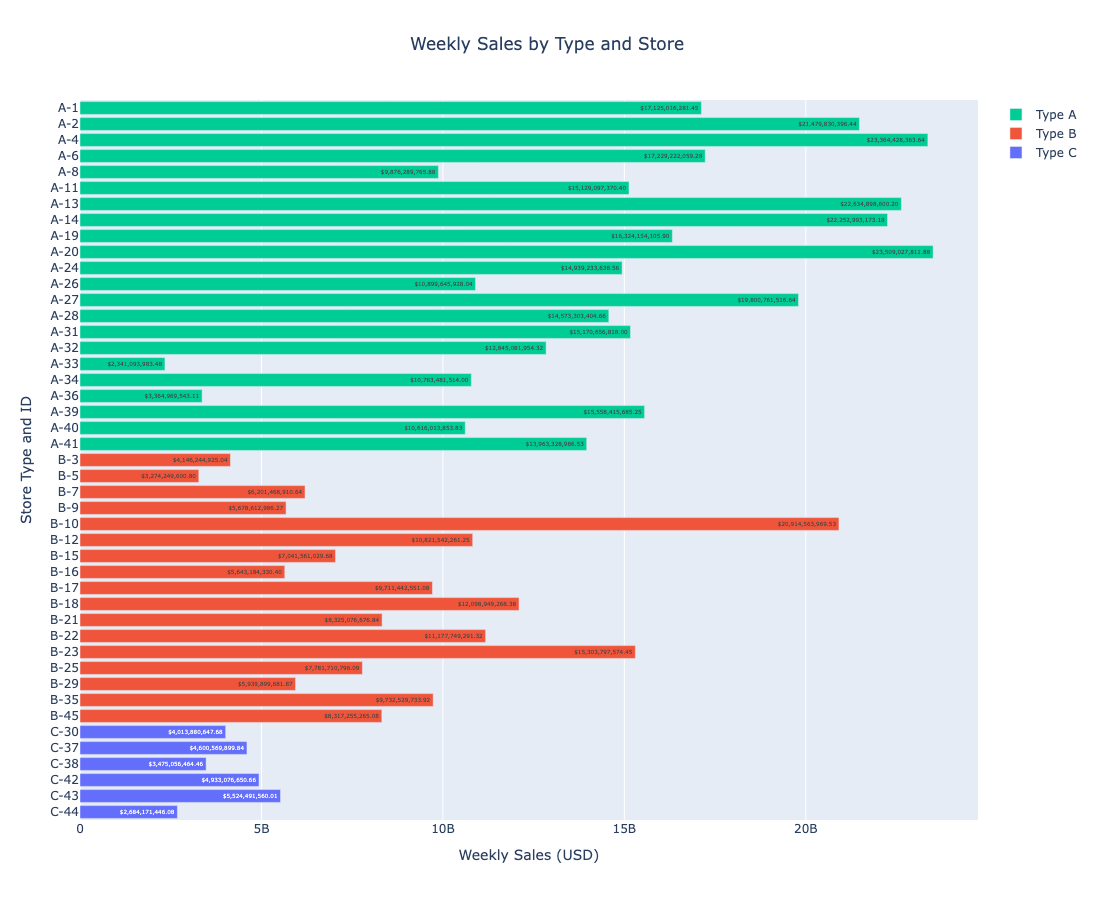

In [80]:
# THIS IS THE UPDATED GROUPED BAR CHART USING go.Figure() TO IMPOSE ADDITIONAL
# CONTROL ON THE CHART.

# Read the data
df_salesbystore = pd.read_sql(sql_sales_by_store_type_and_store_id, conn)

# Force column names to lowercase so Snowflake will match the model table
df_salesbystore.columns = [col.lower() for col in df_salesbystore.columns]

# Sort your DataFrame by store_type for consistent grouping
df_salesbystore = df_salesbystore.sort_values(by=['store_type', 'store_id'], ascending=[True, False])

# Create figure container
fig = go.Figure()

# Loop through each store type and add bars for its store_ids
store_types = df_salesbystore['store_type'].unique()

# Reverse the list of store_types to show A-B-C top-down on the chart
store_types = store_types[::-1]

print(store_types)

for store_type in store_types:
    df_sub = df_salesbystore[df_salesbystore['store_type'] == store_type]
    # Each go.Bar() trace = one group of bars for a given store type (A, B, C)
    fig.add_trace(go.Bar(
        x=df_sub['total_sales'],
        y=[f"{store_type}-{sid}" for sid in df_sub['store_id']],
        name=f"Type {store_type}",
        orientation='h',
        text=df_sub['total_sales'].map("${:,.2f}".format),
        textposition='auto'
    ))

# We reversed the store_types list to plot the bars as A-B-C from the top of the y-axis
# However, that also reversed the legend. Fix that in the update_traces
fig.update_traces(
    selector=dict(name='Type A'),
    legendrank=1
)
fig.update_traces(
    selector=dict(name='Type B'),
    legendrank=2
)
fig.update_traces(
    selector=dict(name='Type C'),
    legendrank=3
)

# Update layout
fig.update_layout(
    title='Weekly Sales by Type and Store',
    xaxis_title='Weekly Sales (USD)',
    yaxis_title='Store Type and ID',
    barmode='group',
    title_x=0.5,
    height=900
)

fig.show()


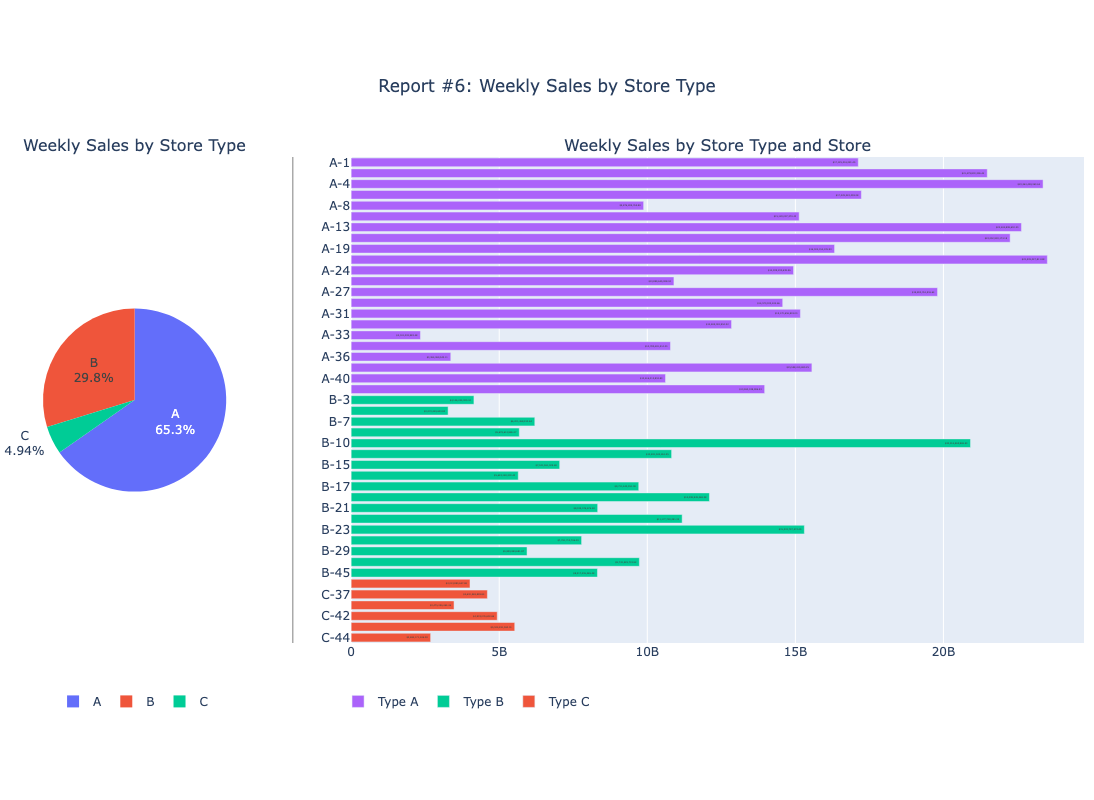

In [75]:
# Let's combine the pie chart and the horizontal grouped bar chart into single dashboard
# type of presentation. 

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[
        {'type': 'domain'}, # row 1: pie chart
        {'type': 'xy'}      # row 1: bar chart
    ]],
    shared_xaxes=False,
    horizontal_spacing=0.12,  # The space between the rows
    column_widths=[0.20, 0.80],
    # row_heights=[0.6, 0.4],
    subplot_titles=("Weekly Sales by Store Type", "Weekly Sales by Store Type and Store")
)

# Next, let's add the pie chart to the first cell in row 1
fig.add_trace(
    go.Pie(
        labels=df['store_type'],
        values=df['total_sales'],
        textinfo='label+percent',
        hovertemplate='Store Type: ${label]<br>Sales: %{value:$,.2f}<extra></extra>',
        legendrank=1  # Specifically start the legend position at 1
    ),
    row=1,
    col=1
)


# Now add the horizontal grouped bar chart

# Loop through each store type and add bars for its store_ids
store_types = df_salesbystore['store_type'].unique()  # ['A', 'B', 'C']

# Reverse the list of store_types to show A-B-C top-down on the chart
store_types = store_types[::-1]

# By reversing the order in which the bar charts are rendered, the legend
# will also be reversed.  We need to fix that by creating a dictionary of
# store types with the order we want, then feed it into the add_trace
# method so it is created in the desired order.
# Create the dictionary with the store_type as the key and the overall sort 
# order position as the value
legend_ranks = {'A':4, 'B':5, 'C':6}

for store_type in store_types:
    df_sub = df_salesbystore[df_salesbystore['store_type'] == store_type]
    # Each go.Bar() trace = one group of bars for a given store type (A, B, C)
    fig.add_trace(
        go.Bar(
            x=df_sub['total_sales'],
            y=[f"{store_type}-{sid}" for sid in df_sub['store_id']],
            name=f"Type {store_type}",
            orientation='h',
            text=df_sub['total_sales'].map("${:,.2f}".format),
            textposition='auto',
            hovertemplate='Store ID: %{y}<br>Total Sales: %{x:$,.2f}<extra></extra>',
            legendrank=legend_ranks[store_type]  # Set the specific overall legend rank
        ),
        row=1,
        col=2
    )

fig.add_trace(
    go.Scatter(
        x=[None],  # No data shown
        y=[None],
        mode='none',
        name="                   ",  # A blank name gives a visual gap
        showlegend=True,
        legendrank=3.5  # between pie (1–3) and bars (4–6)
    ),
    row=1,
    col=2  # or wherever it's needed — it won't actually render
)



# Update layout
fig.update_layout(
    title=dict(
        text="Report #6: Weekly Sales by Store Type",
        y=0.9,
        x=0.5,  # Center
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(
        l=10, 
        r=10, 
        t=0, 
        b=10
    ),  # reduce the left/right margin a bit to help with horizontal scrolling
    width=1080,
    height=800,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="center",
        x=0.27
    )
)

fig.add_shape(
    type="line",
    x0=0.24, x1=0.24,
    y0=0, y1=1,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)


fig.show()

In [ ]:
# Close the connection
conn.close()